In [4]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.decomposition import PCA
from statsmodels.tsa.vector_ar.var_model import VAR
import scipy.optimize

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
libpath = os.path.join(path1p, "lib")

sys.path.insert(0, libpath)
print("Appended library directory", libpath)

# User libraries
from matlab.matlab_yaro_lib import read_neuro_perf
from matlab.matlab_lib import loadmat
from qt_wrapper import gui_fpath

Appended library directory /media/aleksejs/DataHDD/work/codes/theoretical-models/experimental-bridge/TNU2019-Project/src/lib


## 0. Loading data

In [8]:
# Read LVM file from command line
#data_path = gui_fpath("Select data directory", './')
data_path = '../../data/raw/mtp_13_2017_03_22_a/neuro_behaviour'
data, behaviour = read_neuro_perf(data_path)

# Get parameters
nTrials, nTimes, nChannels = data.shape
print("Loaded neuronal data with (nTrials, nTimes, nChannels)=", data.shape)

#pd.DataFrame(behaviour['trials'])

Reading Yaro data from ../../data/raw/mtp_13_2017_03_22_a/neuro_behaviour
Loaded neuronal data with (nTrials, nTimes, nChannels)= (590, 201, 12)


# 1. Autoregression

What to include into model:
1. Autoregressive Dynamics
$$\vec{x}(t+1) = A\vec{x}(t)$$
2. Neural noise, to model input from external sources
$$\vec{x}(t+1) = A\vec{x}(t) + \nu, \;\;\;\;\; \nu \sim \mathcal{N}(\vec{\mu}, \Sigma)$$
3. Input and input-coupling
$$ \vec{x}(t+1) = A\vec{x}(t) + B\vec{u}(t) + C \vec{x}(t) \vec{u}(t) + \nu$$
4. Observable convolution
$$
\begin{eqnarray}
  \tau \dot{y} &=& -y + x \\
  \vec{y}(t+1) &\approx& \alpha \vec{x}(t) + (1 - \alpha) \vec{y}(t), \;\;\;\;\; \alpha = \frac{\Delta t}{\tau}
\end{eqnarray}$$

**TODO**:
* See what tools for autoregressors exist
* Read literature on DCM, understand how it works, how it is different from autoregressor
* For observable autoregressor, is it not equivalent to simply deconvolving data and then using basic deconvolved?
   $$x(t) = y(t) + \frac{y(t+1) - y(t)}{\alpha}$$
   * Ask Yaro if he thinks this makes sense
   * Look for most optimal deconvolution tool for this process

In [1]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [9]:
def unpack(Aarr):
    return Aarr.reshape(nChannels, nChannels)

def model(Data, A):   # Future time step from prev. one
    return Data.dot(A.T)

# def L(Aarr):
#     Amat = unpack(Aarr)
#     data_guess = model(data, Amat)
#     residue = np.linalg.norm(data[:, 1:, :] - data_guess[:, :-1, :])
#     return residue

d_0 = data[:, :-1, :].transpose(2, 0, 1).reshape(nChannels, (nTimes-1)*nTrials)
d_1 = data[:, 1:, :].transpose(2, 0, 1).reshape(nChannels, (nTimes-1)*nTrials)
len_d = d_0.shape[1]

D1 = np.linalg.norm(d_1)**2
D10  = np.einsum('ij, kj', d_1, d_0)
D00 = np.einsum('kj, lj', d_0, d_0)

C_REG = 5.0

def reg(Amat):
    return C_REG*np.sum(np.abs(Amat))

def L2_fast(Aarr):
    Amat = unpack(Aarr)
    B = -2*np.einsum('ij, ij', Amat, D10)
    C = np.einsum('ik,il,kl', Amat, Amat, D00)
    return D1 + B + C + reg(Amat)

def L2_jac(Aarr):
    Amat = unpack(Aarr)
    Jac2D = -2 * (D10 - Amat.dot(D00)) + C_REG*np.sign(Amat)
    return Jac2D.flatten()

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/scipy/optimize/_minimize.py:430: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)


False
Desired error not necessarily achieved due to precision loss.
True
Optimization terminated successfully.
4.7168067326611425 compared to 31.142783566956066


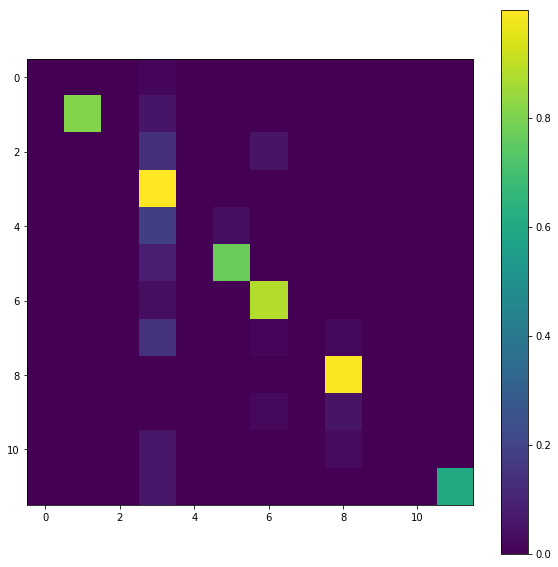

CPU times: user 904 ms, sys: 479 ms, total: 1.38 s
Wall time: 678 ms


In [10]:
%%time
# Example 1:
A0arr = np.diag(np.ones(nChannels)).flatten() + np.random.uniform(0, 0.1, nChannels**2)

bounds = [(0, 10) for i in range(nChannels**2)]
min_obj = scipy.optimize.minimize(L2_fast, A0arr, jac=L2_jac, bounds=bounds, method='CG')#, method='SLSQP')
print(min_obj.success)
print(min_obj.message)
# min_obj = scipy.optimize.minimize(L2_fast, min_obj.x, jac=L2_jac, bounds=bounds, method='L-BFGS-B')
# print(min_obj.success)
# print(min_obj.message)
min_obj = scipy.optimize.minimize(L2_fast, min_obj.x, jac=L2_jac, bounds=bounds, method='SLSQP')
print(min_obj.success)
print(min_obj.message)

A = unpack(min_obj.x)
A[A < 1.0e-10] = 0

# Compute fitness
L2_without_reg = np.sqrt(min_obj.fun - reg(A))
print(L2_without_reg, "compared to", np.linalg.norm(data[:, 1:, :]))

plt.figure(figsize=(10,10))
plt.imshow(unpack(min_obj.x))
plt.colorbar()
plt.show()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.000000,0.0,0.015481,0.0,0.000000,0.000000e+00,0.0,0.000000,0.0,0.0,0.000000
1,0.0,0.813936,0.0,0.056084,0.0,0.000000,1.106285e-08,0.0,0.000000,0.0,0.0,0.000000
2,0.0,0.000000,0.0,0.136574,0.0,0.000000,5.408990e-02,0.0,0.000000,0.0,0.0,0.000000
3,0.0,0.000000,0.0,0.997656,0.0,0.000000,0.000000e+00,0.0,0.000000,0.0,0.0,0.000000
4,0.0,0.000000,0.0,0.186565,0.0,0.035615,0.000000e+00,0.0,0.000000,0.0,0.0,0.000000
5,0.0,0.000000,0.0,0.084893,0.0,0.772132,0.000000e+00,0.0,0.000000,0.0,0.0,0.000000
6,0.0,0.000000,0.0,0.035958,0.0,0.000000,8.817842e-01,0.0,0.000000,0.0,0.0,0.000000
7,0.0,0.000141,0.0,0.145562,0.0,0.000000,1.612271e-02,0.0,0.022841,0.0,0.0,0.000000
8,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000e+00,0.0,0.992472,0.0,0.0,0.000000
9,0.0,0.000000,0.0,0.000791,0.0,0.000000,2.059074e-02,0.0,0.054316,0.0,0.0,0.000000


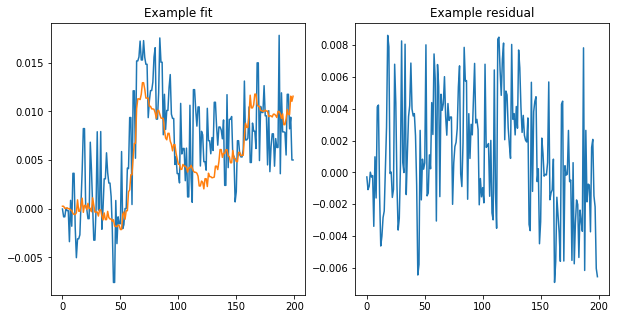

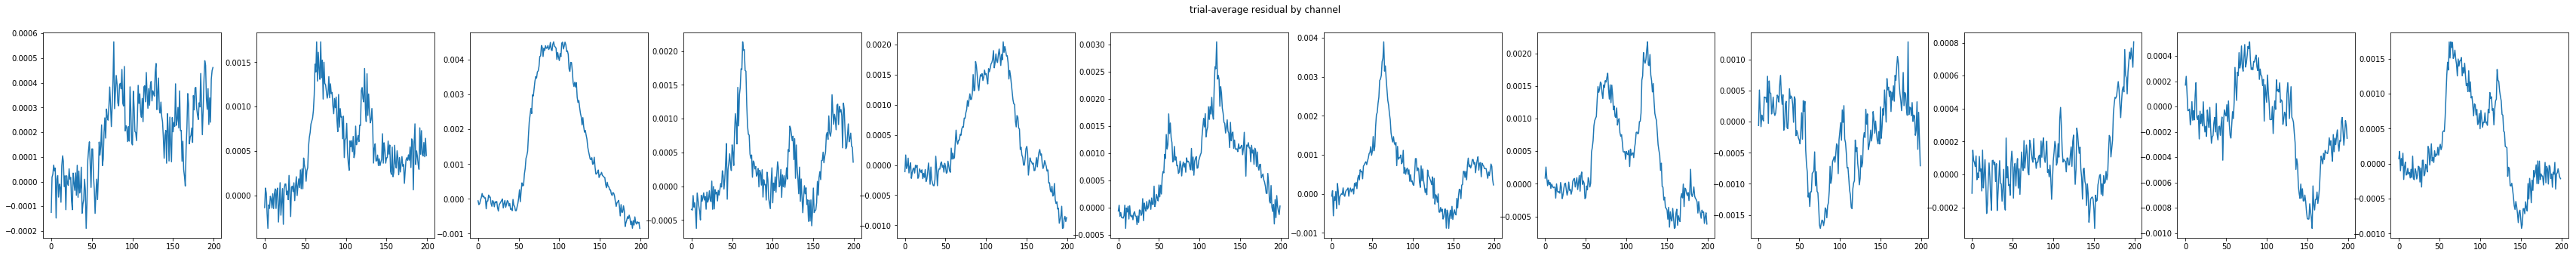

In [13]:
display(pd.DataFrame(A))

Data_model = model(data[:, :-1, :], A)
Residual = data[:, 1:, :] - Data_model

N_CH = 2
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].set_title("Example fit")
ax[1].set_title("Example residual")
ax[0].plot(data[0, 1:, N_CH])
ax[0].plot(Data_model[0, :, N_CH])
ax[1].plot(Residual[0, :, N_CH])
plt.show()

fig, ax = plt.subplots(ncols=nChannels, figsize=(5*nChannels, 5))
fig.suptitle("trial-average residual by channel")
for i in range(nChannels):
    ax[i].plot(np.average(Residual[:, :, i], axis=0))
plt.show()